# House Price Prediction - Data Exploration

This notebook performs comprehensive exploratory data analysis (EDA) on the Kaggle House Prices dataset. 

## Objective
- Understand the structure and characteristics of the dataset
- Identify patterns, trends, and relationships in the data
- Detect missing values and outliers
- Prepare insights for data preprocessing and feature engineering

## Dataset Information
- **Source**: Kaggle House Prices Competition
- **Target**: SalePrice (house sale price in dollars)
- **Features**: 79 explanatory variables describing residential properties

Let's start our exploration!

## 1. Import Required Libraries

We'll import all the essential libraries for data exploration, analysis, and visualization.

In [1]:
# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Try to import optional libraries with fallbacks
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    PLOTLY_AVAILABLE = True
    print("✅ Plotly available for interactive plots")
except ImportError:
    PLOTLY_AVAILABLE = False
    print("⚠️ Plotly not available - using matplotlib instead")

# Statistical analysis
try:
    from scipy import stats
    from scipy.stats import normaltest, skew, kurtosis
    SCIPY_AVAILABLE = True
    print("✅ SciPy available for statistical analysis")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ SciPy not available - using basic statistics")

# Import our custom utility functions
import sys
import os
sys.path.append(os.path.join('..', 'src'))

try:
    from utils import *
    UTILS_AVAILABLE = True
    print("✅ Custom utilities available")
except ImportError:
    UTILS_AVAILABLE = False
    print("⚠️ Custom utilities not available - using basic functions")

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("✅ Core libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

# Define basic utility functions if custom utils not available
if not UTILS_AVAILABLE:
    def load_data(train_path, test_path):
        """Basic data loading function."""
        try:
            train_df = pd.read_csv(train_path)
            test_df = pd.read_csv(test_path)
            print(f"Training data shape: {train_df.shape}")
            print(f"Test data shape: {test_df.shape}")
            return train_df, test_df
        except FileNotFoundError as e:
            print(f"Error loading data: {e}")
            return None, None
    
    def get_missing_data_info(df):
        """Get missing data information."""
        missing_data = df.isnull().sum()
        missing_percent = 100 * missing_data / len(df)
        
        missing_table = pd.DataFrame({
            'Missing Count': missing_data,
            'Missing Percentage': missing_percent
        })
        
        return missing_table[missing_table['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
    
    def detect_outliers_iqr(series, factor=1.5):
        """Detect outliers using IQR method."""
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        return (series < lower_bound) | (series > upper_bound)
    
    print("✅ Basic utility functions defined")

⚠️ Plotly not available - using matplotlib instead
✅ SciPy available for statistical analysis
✅ Custom utilities available
✅ Core libraries imported successfully!
Pandas version: 2.2.2
NumPy version: 1.26.4
Matplotlib version: 3.8.4
Seaborn version: 0.13.2


## 2. Load the House Prices Dataset

⚠️ **Important**: Before running this section, please ensure you have downloaded the dataset from Kaggle:
1. Go to [Kaggle House Prices Competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)
2. Download the following files:
   - `train.csv`
   - `test.csv`
   - `data_description.txt`
3. Place them in the `../data/` directory

Let's load and examine the basic structure of our data.

In [2]:
# Define file paths
train_path = '../data/train.csv'
test_path = '../data/test.csv'

# Load the datasets
try:
    train_df, test_df = load_data(train_path, test_path)
    
    if train_df is not None and test_df is not None:
        print("✅ Data loaded successfully!")
        print("\n" + "="*60)
        print("DATASET OVERVIEW")
        print("="*60)
        print(f"Training set shape: {train_df.shape}")
        print(f"Test set shape: {test_df.shape}")
        print(f"Total features: {len(train_df.columns) - 1}")  # -1 for target column
        print(f"Target variable: SalePrice (only in training set)")
        
        # Display first few rows
        print("\n📊 First 5 rows of training data:")
        display(train_df.head())
        
except FileNotFoundError:
    print("❌ Dataset files not found!")
    print("Please download the files from Kaggle and place them in the ../data/ directory")
    print("Files needed: train.csv, test.csv, data_description.txt")

Training data shape: (1460, 81)
Test data shape: (1459, 80)
✅ Data loaded successfully!

DATASET OVERVIEW
Training set shape: (1460, 81)
Test set shape: (1459, 80)
Total features: 80
Target variable: SalePrice (only in training set)

📊 First 5 rows of training data:


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 3. Explore Basic Data Information

Let's understand the structure, data types, and basic statistics of our dataset.

In [3]:
# Get comprehensive data summary
if 'train_df' in locals():
    print("="*50)
    print("TRAINING DATA SUMMARY")
    print("="*50)
    print(f"Shape: {train_df.shape}")
    print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types breakdown
    numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"\n📈 FEATURE TYPES BREAKDOWN")
    print(f"{'='*40}")
    print(f"Numerical features: {len(numerical_features)}")
    print(f"Categorical features: {len(categorical_features)}")
    
    print(f"\n🔢 NUMERICAL FEATURES:")
    print(", ".join(numerical_features[:10]) + "..." if len(numerical_features) > 10 else ", ".join(numerical_features))
    
    print(f"\n📝 CATEGORICAL FEATURES:")
    print(", ".join(categorical_features[:10]) + "..." if len(categorical_features) > 10 else ", ".join(categorical_features))
    
    # Missing data
    missing_data = get_missing_data_info(train_df)
    if not missing_data.empty:
        print(f"\nMissing data:")
        print(f"  Features with missing values: {len(missing_data)}")
        print(f"  Total missing values: {missing_data['Missing Count'].sum()}")
    else:
        print("\nNo missing data found!")
    
    # Basic statistics for numerical features
    print(f"\n📊 BASIC STATISTICS FOR NUMERICAL FEATURES:")
    display(train_df.describe().round(2))
else:
    print("❌ Please load the data first!")

TRAINING DATA SUMMARY
Shape: (1460, 81)
Memory usage: 3.43 MB

📈 FEATURE TYPES BREAKDOWN
Numerical features: 38
Categorical features: 43

🔢 NUMERICAL FEATURES:
Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1...

📝 CATEGORICAL FEATURES:
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1...

Missing data:
  Features with missing values: 19
  Total missing values: 7829

📊 BASIC STATISTICS FOR NUMERICAL FEATURES:

📈 FEATURE TYPES BREAKDOWN
Numerical features: 38
Categorical features: 43

🔢 NUMERICAL FEATURES:
Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, YearBuilt, YearRemodAdd, MasVnrArea, BsmtFinSF1...

📝 CATEGORICAL FEATURES:
MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1...

Missing data:
  Features with missing values: 19
  Total missing values: 7829

📊 BASIC STATISTICS FOR NUMERICAL FEATURES

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.00,1460.0,1201.00,1460.00,1460.00,1460.00,1460.00,1460.00,1452.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1379.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.00,1460.0
mean,730.50,56.9,70.05,10516.83,6.10,5.58,1971.27,1984.87,103.69,443.64,46.55,567.24,1057.43,1162.63,346.99,5.84,1515.46,0.43,0.06,1.57,0.38,2.87,1.05,6.52,0.61,1978.51,1.77,472.98,94.24,46.66,21.95,3.41,15.06,2.76,43.49,6.32,2007.82,180921.2
std,421.61,42.3,24.28,9981.26,1.38,1.11,30.20,20.65,181.07,456.10,161.32,441.87,438.71,386.59,436.53,48.62,525.48,0.52,0.24,0.55,0.50,0.82,0.22,1.63,0.64,24.69,0.75,213.80,125.34,66.26,61.12,29.32,55.76,40.18,496.12,2.70,1.33,79442.5
min,1.00,20.0,21.00,1300.00,1.00,1.00,1872.00,1950.00,0.00,0.00,0.00,0.00,0.00,334.00,0.00,0.00,334.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,0.00,1900.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,2006.00,34900.0
25%,365.75,20.0,59.00,7553.50,5.00,5.00,1954.00,1967.00,0.00,0.00,0.00,223.00,795.75,882.00,0.00,0.00,1129.50,0.00,0.00,1.00,0.00,2.00,1.00,5.00,0.00,1961.00,1.00,334.50,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.00,2007.00,129975.0
50%,730.50,50.0,69.00,9478.50,6.00,5.00,1973.00,1994.00,0.00,383.50,0.00,477.50,991.50,1087.00,0.00,0.00,1464.00,0.00,0.00,2.00,0.00,3.00,1.00,6.00,1.00,1980.00,2.00,480.00,0.00,25.00,0.00,0.00,0.00,0.00,0.00,6.00,2008.00,163000.0
75%,1095.25,70.0,80.00,11601.50,7.00,6.00,2000.00,2004.00,166.00,712.25,0.00,808.00,1298.25,1391.25,728.00,0.00,1776.75,1.00,0.00,2.00,1.00,3.00,1.00,7.00,1.00,2002.00,2.00,576.00,168.00,68.00,0.00,0.00,0.00,0.00,0.00,8.00,2009.00,214000.0
max,1460.00,190.0,313.00,215245.00,10.00,9.00,2010.00,2010.00,1600.00,5644.00,1474.00,2336.00,6110.00,4692.00,2065.00,572.00,5642.00,3.00,2.00,3.00,2.00,8.00,3.00,14.00,3.00,2010.00,4.00,1418.00,857.00,547.00,552.00,508.00,480.00,738.00,15500.00,12.00,2010.00,755000.0


## 4. Target Variable Analysis

The target variable `SalePrice` is what we want to predict. Let's analyze its distribution and characteristics.

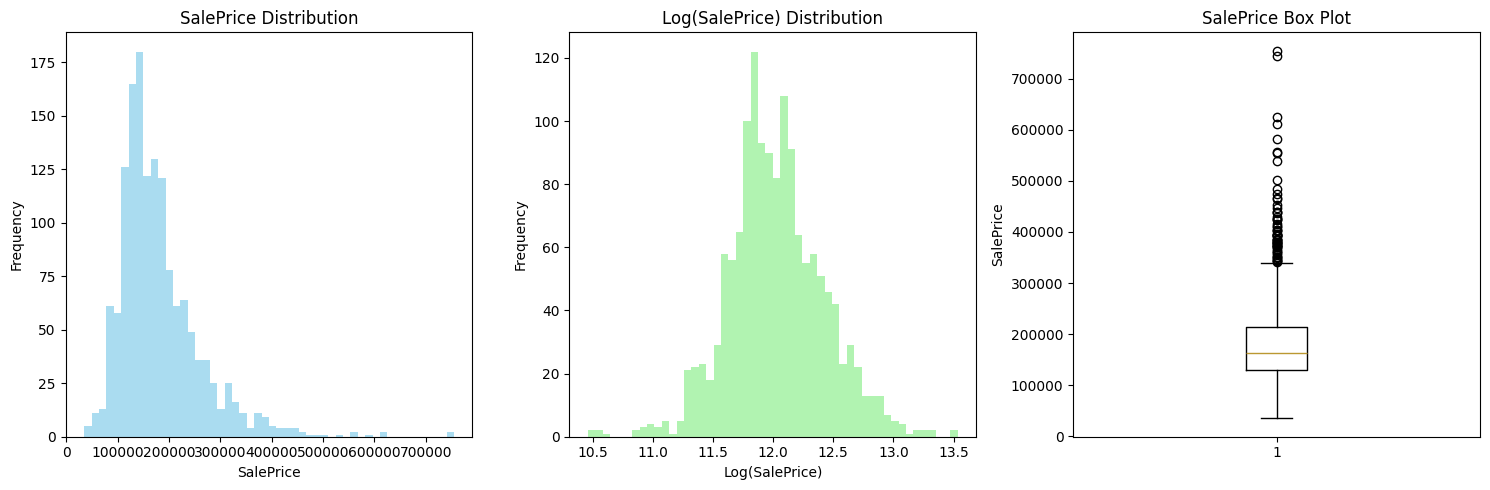


🧮 STATISTICAL ANALYSIS:
Mean: $180,921.20
Median: $163,000.00
Std: $79,442.50
Min: $34,900.00
Max: $755,000.00
Skewness: 1.879 (Right-skewed)
Normality test (D'Agostino): p-value = 2.28e-133
Is normally distributed: False
Kurtosis: 6.510 (Heavy-tailed)

💰 PRICE RANGES:
Q1 (25%): $129,975
Q2 (50%): $163,000
Q3 (75%): $214,000
IQR: $84,025

Outliers detected: 61 (4.2%)


In [4]:
# Analyze target variable distribution
if 'train_df' in locals() and 'SalePrice' in train_df.columns:
    target = train_df['SalePrice']
    
    # Create distribution plots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original distribution
    axes[0].hist(target, bins=50, alpha=0.7, color='skyblue')
    axes[0].set_title('SalePrice Distribution')
    axes[0].set_xlabel('SalePrice')
    axes[0].set_ylabel('Frequency')
    
    # Log-transformed distribution
    axes[1].hist(np.log1p(target), bins=50, alpha=0.7, color='lightgreen')
    axes[1].set_title('Log(SalePrice) Distribution')
    axes[1].set_xlabel('Log(SalePrice)')
    axes[1].set_ylabel('Frequency')
    
    # Box plot
    axes[2].boxplot(target)
    axes[2].set_title('SalePrice Box Plot')
    axes[2].set_ylabel('SalePrice')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n🧮 STATISTICAL ANALYSIS:")
    print(f"{'='*40}")
    print(f"Mean: ${target.mean():,.2f}")
    print(f"Median: ${target.median():,.2f}")
    print(f"Std: ${target.std():,.2f}")
    print(f"Min: ${target.min():,.2f}")
    print(f"Max: ${target.max():,.2f}")
    
    # Basic skewness calculation
    mean_val = target.mean()
    std_val = target.std()
    n = len(target)
    skewness = ((target - mean_val) / std_val).pow(3).sum() / n
    
    print(f"Skewness: {skewness:.3f} ({'Right-skewed' if skewness > 0 else 'Left-skewed'})")
    
    if SCIPY_AVAILABLE:
        # More advanced statistical tests if scipy is available
        stat, p_value = normaltest(target)
        print(f"Normality test (D'Agostino): p-value = {p_value:.2e}")
        print(f"Is normally distributed: {p_value > 0.05}")
        
        kurt = kurtosis(target)
        print(f"Kurtosis: {kurt:.3f} ({'Heavy-tailed' if kurt > 0 else 'Light-tailed'})")
    
    # Price ranges
    quartiles = target.quantile([0.25, 0.5, 0.75])
    print(f"\n💰 PRICE RANGES:")
    print(f"{'='*40}")
    print(f"Q1 (25%): ${quartiles[0.25]:,.0f}")
    print(f"Q2 (50%): ${quartiles[0.5]:,.0f}")
    print(f"Q3 (75%): ${quartiles[0.75]:,.0f}")
    print(f"IQR: ${quartiles[0.75] - quartiles[0.25]:,.0f}")
    
    # Detect outliers using IQR method
    outliers = detect_outliers_iqr(target)
    print(f"\nOutliers detected: {outliers.sum()} ({outliers.sum()/len(target)*100:.1f}%)")
else:
    print("❌ Please load the training data first!")

## 5. Missing Values Analysis

Missing data is common in real-world datasets. Let's identify and analyze missing values patterns.

🔍 MISSING VALUES ANALYSIS - TRAINING DATA
Features with missing values: 19
Total missing values: 7,829
Percentage of dataset: 6.62%

📊 TOP 15 FEATURES WITH MISSING VALUES:


,Missing Count,Missing Percentage
PoolQC,1453,99.520548
MiscFeature,1406,96.301370
Alley,1369,93.767123
Fence,1179,80.753425
MasVnrType,872,59.726027
FireplaceQu,690,47.260274
LotFrontage,259,17.739726
GarageType,81,5.547945
GarageYrBlt,81,5.547945
GarageFinish,81,5.547945



📈 MISSING DATA VISUALIZATION:


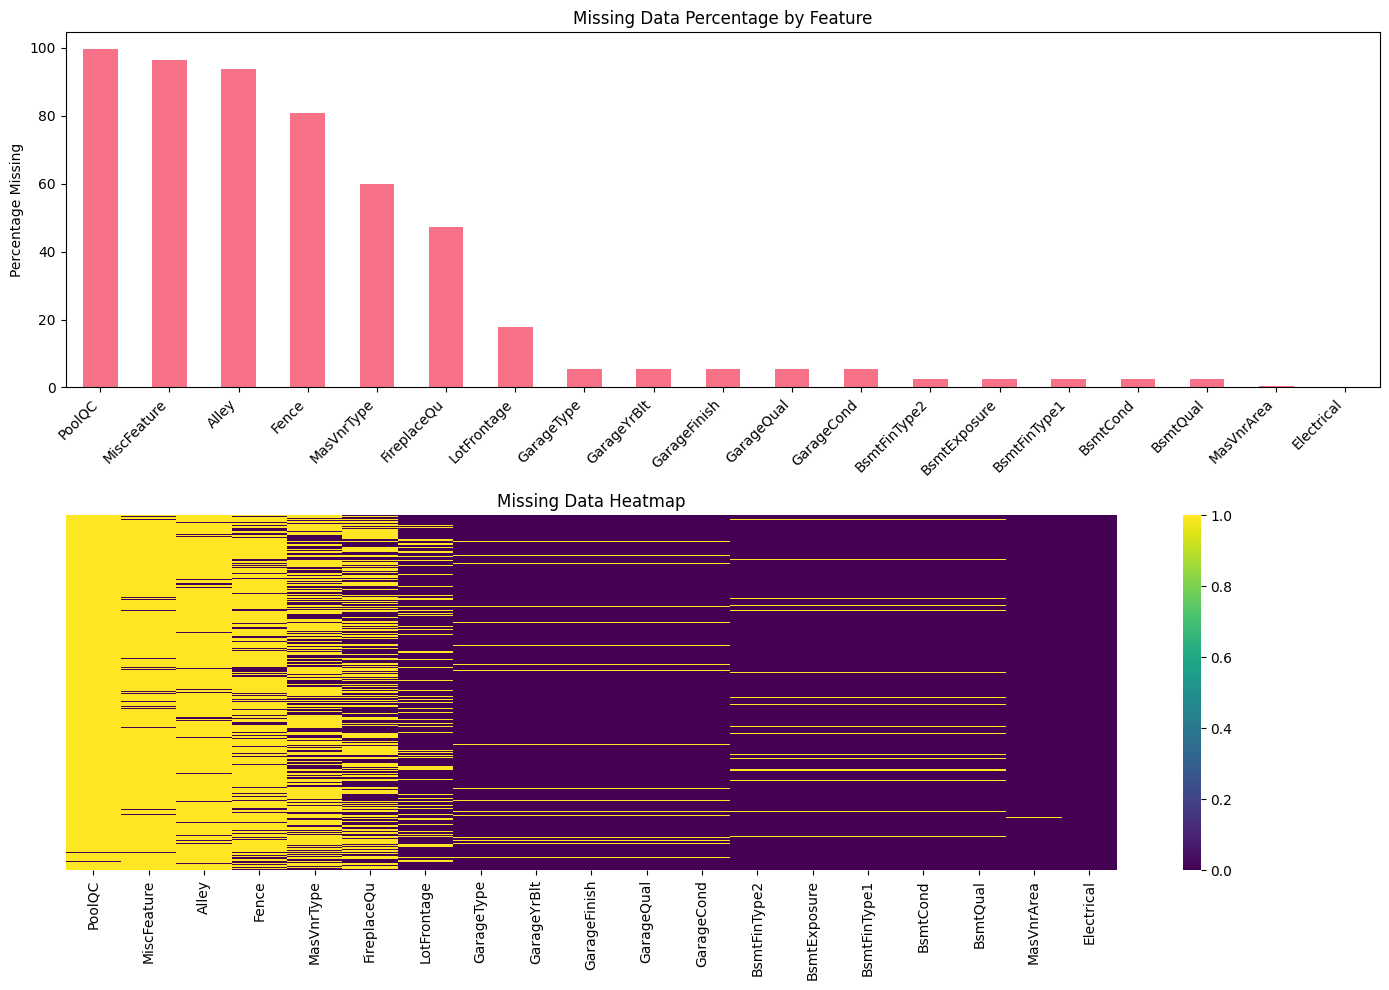


🎯 MISSING DATA CATEGORIES:
High missing (>50%): 5 features
   PoolQC, MiscFeature, Alley, Fence, MasVnrType
Medium missing (5-50%): 7 features
   FireplaceQu, LotFrontage, GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond
Low missing (<5%): 7 features
   BsmtFinType2, BsmtExposure, BsmtFinType1, BsmtCond, BsmtQual, MasVnrArea, Electrical

🔍 MISSING VALUES ANALYSIS - TEST DATA
Features with missing values: 33
Total missing values: 7,878
Percentage of dataset: 6.75%


In [5]:
# Analyze missing values in training data
if 'train_df' in locals():
    print("🔍 MISSING VALUES ANALYSIS - TRAINING DATA")
    print("="*50)
    
    missing_info = get_missing_data_info(train_df)
    
    if not missing_info.empty:
        print(f"Features with missing values: {len(missing_info)}")
        print(f"Total missing values: {missing_info['Missing Count'].sum():,}")
        print(f"Percentage of dataset: {missing_info['Missing Count'].sum() / (train_df.shape[0] * train_df.shape[1]) * 100:.2f}%")
        
        print(f"\n📊 TOP 15 FEATURES WITH MISSING VALUES:")
        display(missing_info.head(15))
        
        # Visualize missing data patterns
        print(f"\n📈 MISSING DATA VISUALIZATION:")
        plot_missing_data(train_df, figsize=(14, 10))
        
        # Group features by missingness level
        high_missing = missing_info[missing_info['Missing Percentage'] > 50]
        medium_missing = missing_info[(missing_info['Missing Percentage'] > 5) & 
                                     (missing_info['Missing Percentage'] <= 50)]
        low_missing = missing_info[missing_info['Missing Percentage'] <= 5]
        
        print(f"\n🎯 MISSING DATA CATEGORIES:")
        print(f"{'='*40}")
        print(f"High missing (>50%): {len(high_missing)} features")
        if len(high_missing) > 0:
            print(f"   {', '.join(high_missing.index.tolist())}")
        
        print(f"Medium missing (5-50%): {len(medium_missing)} features")
        if len(medium_missing) > 0:
            print(f"   {', '.join(medium_missing.index.tolist())}")
        
        print(f"Low missing (<5%): {len(low_missing)} features")
        if len(low_missing) > 0:
            print(f"   {', '.join(low_missing.index.tolist())}")
    else:
        print("✅ No missing values found in the training data!")
        
    # Check test data as well
    if 'test_df' in locals():
        print(f"\n🔍 MISSING VALUES ANALYSIS - TEST DATA")
        print("="*50)
        
        test_missing_info = get_missing_data_info(test_df)
        
        if not test_missing_info.empty:
            print(f"Features with missing values: {len(test_missing_info)}")
            print(f"Total missing values: {test_missing_info['Missing Count'].sum():,}")
            print(f"Percentage of dataset: {test_missing_info['Missing Count'].sum() / (test_df.shape[0] * test_df.shape[1]) * 100:.2f}%")
        else:
            print("✅ No missing values found in the test data!")
else:
    print("❌ Please load the data first!")

## 6. Correlation Analysis

Understanding relationships between features and the target variable helps identify the most important predictors.

🔗 CORRELATION ANALYSIS WITH TARGET VARIABLE
Analyzing correlations for 38 numerical features

🏆 TOP 15 FEATURES MOST CORRELATED WITH SALEPRICE:
-------------------------------------------------------
 1. OverallQual              : 0.791
 2. GrLivArea                : 0.709
 3. GarageCars               : 0.640
 4. GarageArea               : 0.623
 5. TotalBsmtSF              : 0.614
 6. 1stFlrSF                 : 0.606
 7. FullBath                 : 0.561
 8. TotRmsAbvGrd             : 0.534
 9. YearBuilt                : 0.523
10. YearRemodAdd             : 0.507
11. GarageYrBlt              : 0.486
12. MasVnrArea               : 0.477
13. Fireplaces               : 0.467
14. BsmtFinSF1               : 0.386
15. LotFrontage              : 0.352


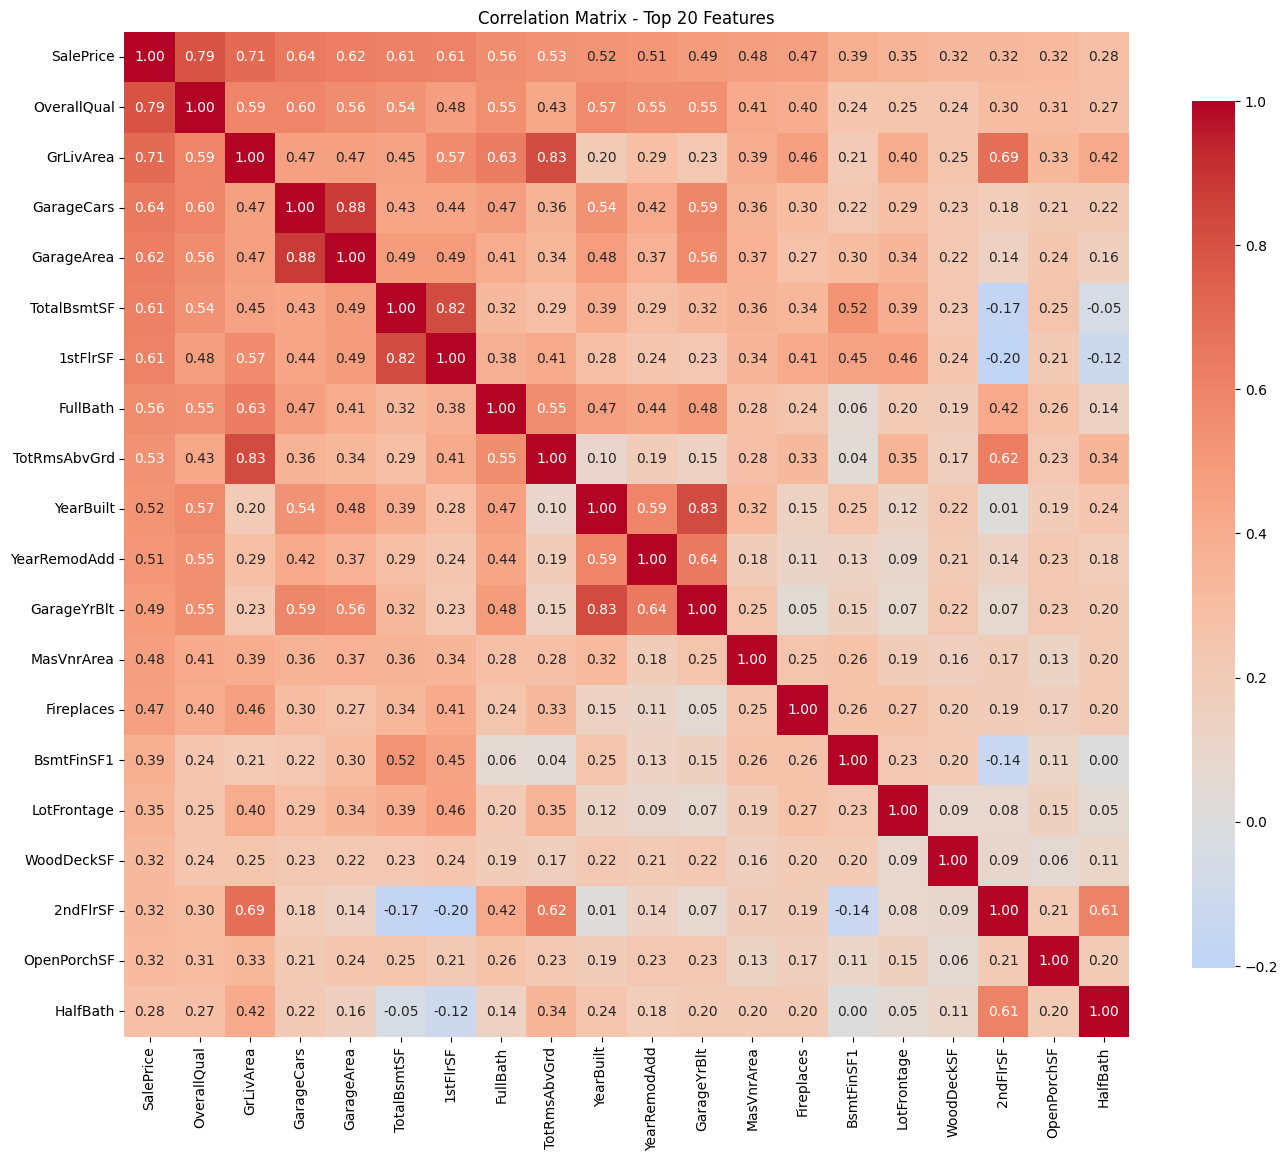


Top 20 features correlated with SalePrice:
 1. SalePrice           : 1.000
 2. OverallQual         : 0.791
 3. GrLivArea           : 0.709
 4. GarageCars          : 0.640
 5. GarageArea          : 0.623
 6. TotalBsmtSF         : 0.614
 7. 1stFlrSF            : 0.606
 8. FullBath            : 0.561
 9. TotRmsAbvGrd        : 0.534
10. YearBuilt           : 0.523
11. YearRemodAdd        : 0.507
12. GarageYrBlt         : 0.486
13. MasVnrArea          : 0.477
14. Fireplaces          : 0.467
15. BsmtFinSF1          : 0.386
16. LotFrontage         : 0.352
17. WoodDeckSF          : 0.324
18. 2ndFlrSF            : 0.319
19. OpenPorchSF         : 0.316
20. HalfBath            : 0.284


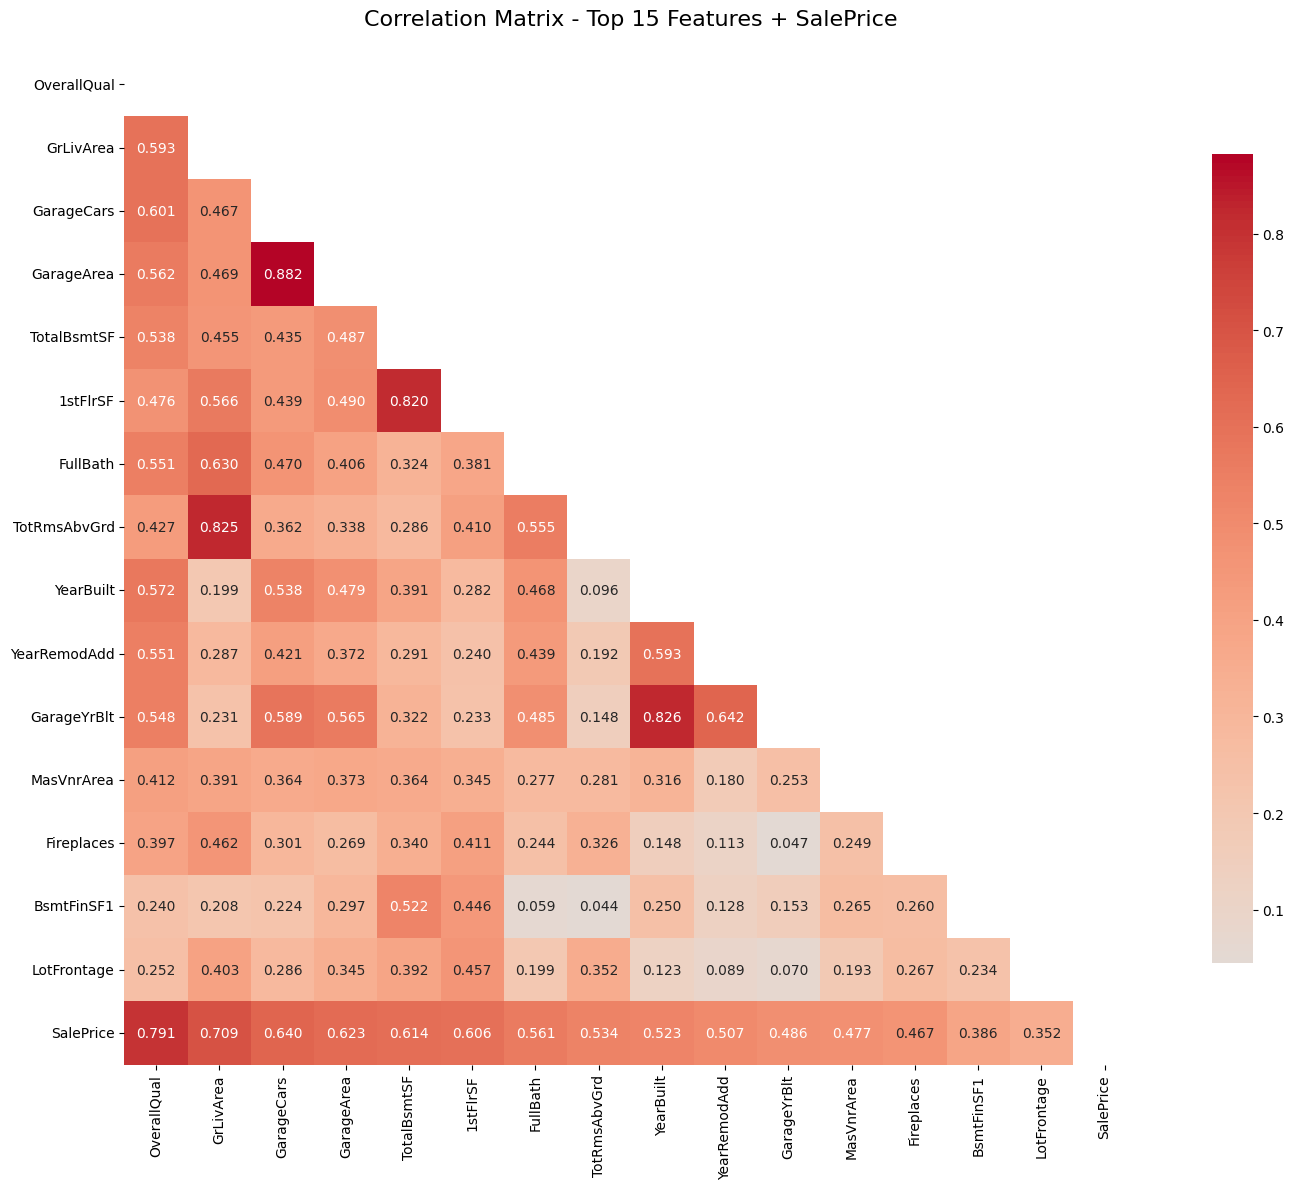


⚠️  HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.8):
------------------------------------------------------------
YearBuilt ↔ GarageYrBlt: 0.826
TotalBsmtSF ↔ 1stFlrSF: 0.820
GrLivArea ↔ TotRmsAbvGrd: 0.825
GarageCars ↔ GarageArea: 0.882

💡 Consider removing one feature from highly correlated pairs to reduce multicollinearity.


In [6]:
# Correlation analysis with target variable
if 'train_df' in locals() and 'SalePrice' in train_df.columns:
    print("🔗 CORRELATION ANALYSIS WITH TARGET VARIABLE")
    print("="*50)
    
    # Get numerical features only for correlation analysis
    numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Analyzing correlations for {len(numerical_features)} numerical features")
    
    # Calculate correlations with SalePrice
    correlations = train_df[numerical_features].corr()['SalePrice'].abs().sort_values(ascending=False)
    
    # Remove SalePrice itself
    correlations = correlations.drop('SalePrice')
    
    print(f"\n🏆 TOP 15 FEATURES MOST CORRELATED WITH SALEPRICE:")
    print("-" * 55)
    for i, (feature, corr) in enumerate(correlations.head(15).items(), 1):
        print(f"{i:2d}. {feature:25s}: {corr:.3f}")
    
    # Visualize correlation matrix for top features
    plot_correlation_matrix(train_df[numerical_features], 'SalePrice', top_n=20, figsize=(14, 12))
    
    # Create correlation heatmap with SalePrice
    plt.figure(figsize=(16, 12))
    top_corr_features = correlations.head(15).index.tolist() + ['SalePrice']
    correlation_matrix = train_df[top_corr_features].corr()
    
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix - Top 15 Features + SalePrice', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()
    
    # Identify highly correlated feature pairs (multicollinearity)
    print(f"\n⚠️  HIGHLY CORRELATED FEATURE PAIRS (|correlation| > 0.8):")
    print("-" * 60)
    
    corr_matrix = train_df[numerical_features].corr()
    high_corr_pairs = []
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:
                feature1 = corr_matrix.columns[i]
                feature2 = corr_matrix.columns[j]
                correlation = corr_matrix.iloc[i, j]
                high_corr_pairs.append((feature1, feature2, correlation))
    
    if high_corr_pairs:
        for feature1, feature2, corr in high_corr_pairs:
            print(f"{feature1} ↔ {feature2}: {corr:.3f}")
        print(f"\n💡 Consider removing one feature from highly correlated pairs to reduce multicollinearity.")
    else:
        print("No highly correlated feature pairs found.")
        
else:
    print("❌ Please load the training data first!")

## 7. Categorical Features Exploration

Let's analyze the categorical features to understand their distributions and relationships with house prices.

📝 CATEGORICAL FEATURES ANALYSIS
Number of categorical features: 43
Categorical features: MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConfig, LandSlope, Neighborhood, Condition1...

🎯 CATEGORICAL FEATURE CARDINALITY:
----------------------------------------


,Feature,Unique_Values,Total_Non_Null,Cardinality_Ratio
8,Neighborhood,25,1460,0.017123
16,Exterior2nd,16,1460,0.010959
15,Exterior1st,15,1460,0.010274
41,SaleType,9,1460,0.006164
9,Condition1,9,1460,0.006164
10,Condition2,8,1460,0.005479
12,HouseStyle,8,1460,0.005479
14,RoofMatl,8,1460,0.005479
31,Functional,7,1460,0.004795
25,BsmtFinType2,6,1422,0.004219



📊 CARDINALITY CATEGORIES:
High cardinality (>10): 3 features
Medium cardinality (5-10): 13 features
Low cardinality (≤5): 27 features


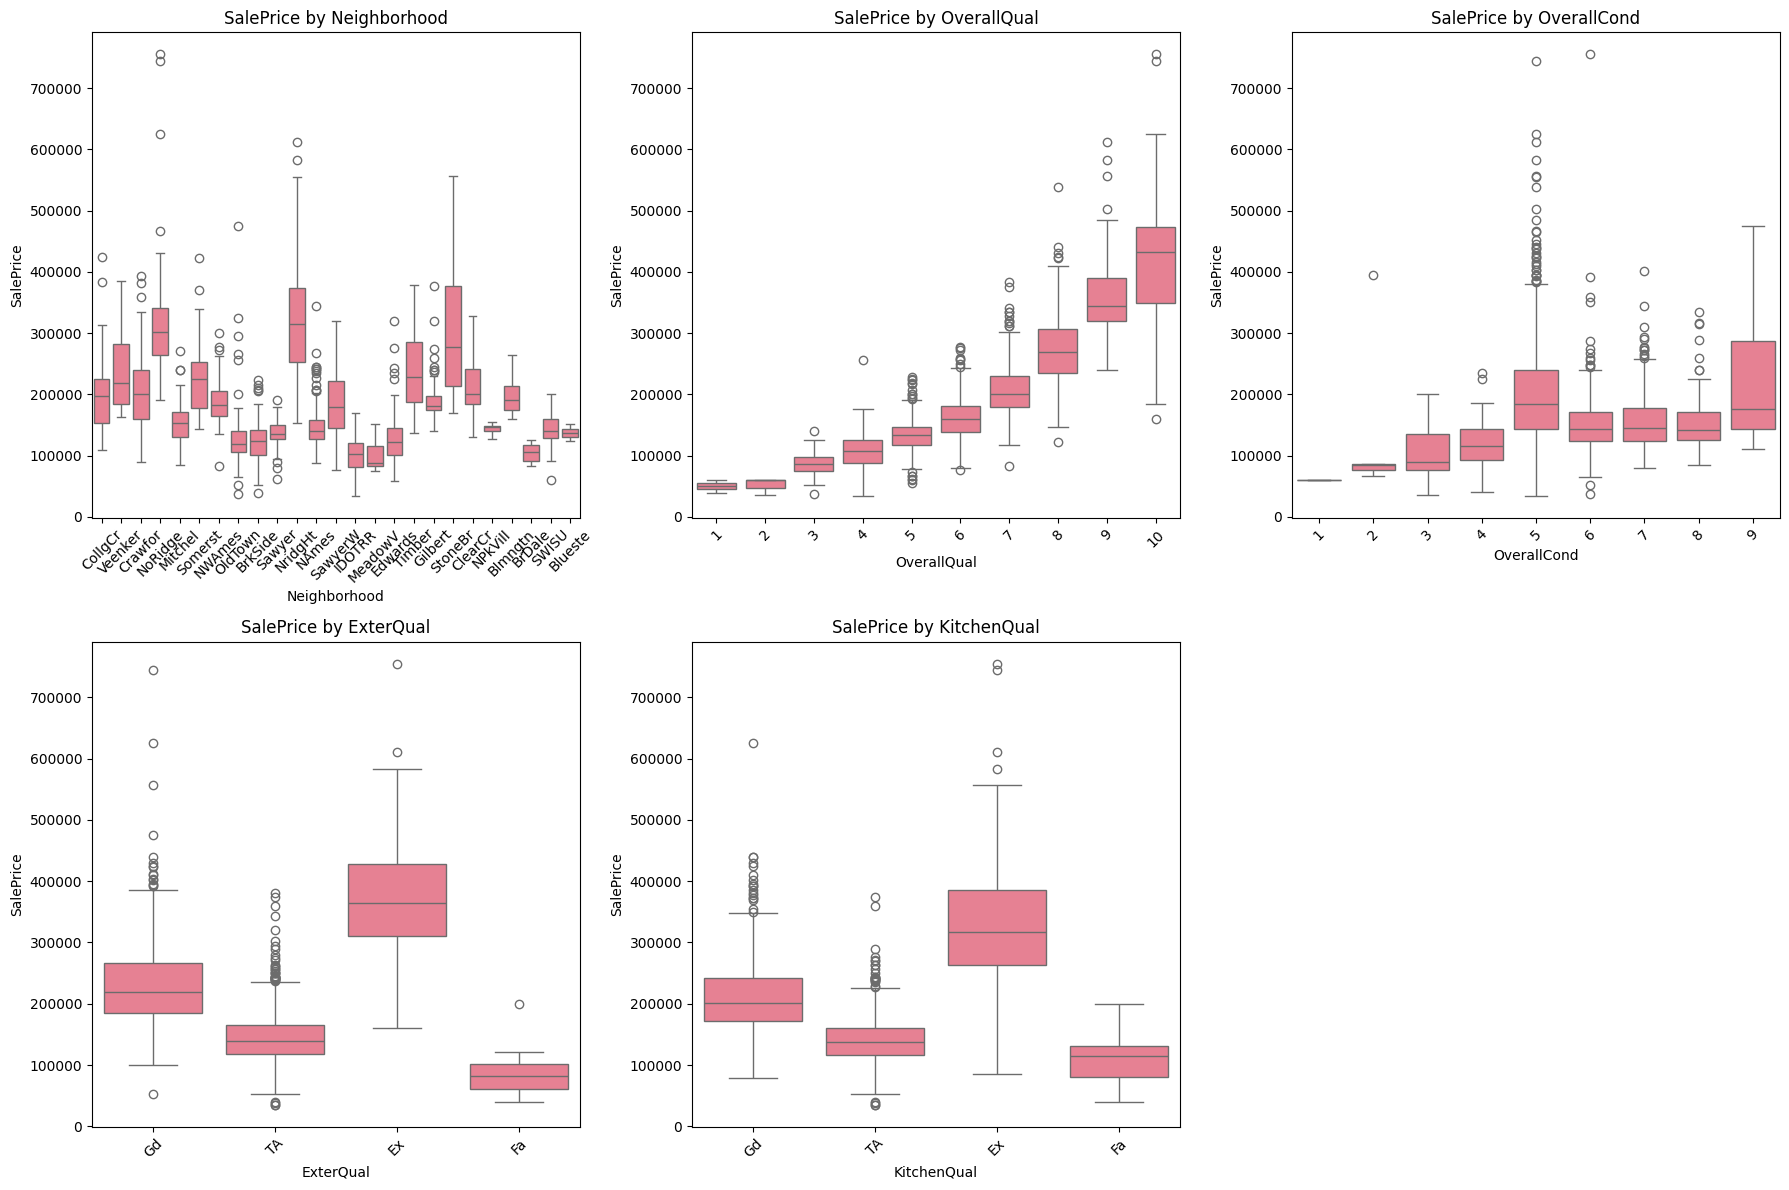


📈 VALUE DISTRIBUTIONS FOR KEY FEATURES:

Neighborhood:
Neighborhood
NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
Name: count, dtype: int64
... and 15 more categories

OverallQual:
OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

OverallCond:
OverallCond
5    821
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: count, dtype: int64


In [7]:
# Explore categorical features
if 'train_df' in locals():
    print("📝 CATEGORICAL FEATURES ANALYSIS")
    print("="*40)
    
    # Get categorical features
    categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
    
    print(f"Number of categorical features: {len(categorical_features)}")
    print(f"Categorical features: {', '.join(categorical_features[:10])}{'...' if len(categorical_features) > 10 else ''}")
    
    # Analyze cardinality (number of unique values)
    print(f"\n🎯 CATEGORICAL FEATURE CARDINALITY:")
    print("-" * 40)
    
    cardinality_info = []
    for feature in categorical_features:
        unique_count = train_df[feature].nunique()
        total_count = train_df[feature].count()  # Non-null count
        cardinality_info.append({
            'Feature': feature,
            'Unique_Values': unique_count,
            'Total_Non_Null': total_count,
            'Cardinality_Ratio': unique_count / total_count if total_count > 0 else 0
        })
    
    cardinality_df = pd.DataFrame(cardinality_info).sort_values('Unique_Values', ascending=False)
    display(cardinality_df.head(15))
    
    # Categorize by cardinality
    high_cardinality = cardinality_df[cardinality_df['Unique_Values'] > 10]['Feature'].tolist()
    medium_cardinality = cardinality_df[(cardinality_df['Unique_Values'] > 5) & 
                                       (cardinality_df['Unique_Values'] <= 10)]['Feature'].tolist()
    low_cardinality = cardinality_df[cardinality_df['Unique_Values'] <= 5]['Feature'].tolist()
    
    print(f"\n📊 CARDINALITY CATEGORIES:")
    print(f"High cardinality (>10): {len(high_cardinality)} features")
    print(f"Medium cardinality (5-10): {len(medium_cardinality)} features") 
    print(f"Low cardinality (≤5): {len(low_cardinality)} features")
    
    # Visualize some key categorical features
    key_categorical_features = ['Neighborhood', 'OverallQual', 'OverallCond', 'ExterQual', 'KitchenQual']
    available_features = [f for f in key_categorical_features if f in train_df.columns]
    
    if available_features and 'SalePrice' in train_df.columns:
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        axes = axes.ravel()
        
        for i, feature in enumerate(available_features[:6]):
            if i < len(axes):
                # Create box plot
                if feature in train_df.columns:
                    sns.boxplot(data=train_df, x=feature, y='SalePrice', ax=axes[i])
                    axes[i].set_title(f'SalePrice by {feature}')
                    axes[i].tick_params(axis='x', rotation=45)
        
        # Hide any unused subplots
        for i in range(len(available_features), len(axes)):
            axes[i].set_visible(False)
        
        plt.tight_layout()
        plt.show()
        
        # Show value counts for a few key features
        print(f"\n📈 VALUE DISTRIBUTIONS FOR KEY FEATURES:")
        for feature in available_features[:3]:
            if feature in train_df.columns:
                print(f"\n{feature}:")
                value_counts = train_df[feature].value_counts()
                print(value_counts.head(10))
                
                if len(value_counts) > 10:
                    print(f"... and {len(value_counts) - 10} more categories")
    
else:
    print("❌ Please load the training data first!")

## 8. Key Insights and Next Steps

Let's summarize our key findings from the exploratory data analysis and outline next steps.

In [8]:
# Generate summary insights
if 'train_df' in locals():
    print("🎯 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    # Dataset overview
    numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = train_df.select_dtypes(include=['object']).columns.tolist()
    missing_info = get_missing_data_info(train_df)
    
    print(f"📊 DATASET OVERVIEW:")
    print(f"   • Total samples: {train_df.shape[0]:,}")
    print(f"   • Total features: {train_df.shape[1] - 1}")  # -1 for target
    print(f"   • Numerical features: {len(numerical_features) - 1}")  # -1 for SalePrice
    print(f"   • Categorical features: {len(categorical_features)}")
    
    # Target variable insights
    if 'SalePrice' in train_df.columns:
        target = train_df['SalePrice']
        print(f"\n🏠 TARGET VARIABLE (SalePrice):")
        print(f"   • Price range: ${target.min():,.0f} - ${target.max():,.0f}")
        print(f"   • Median price: ${target.median():,.0f}")
        print(f"   • Distribution: {'Right-skewed' if target.skew() > 0 else 'Left-skewed'} (skewness: {target.skew():.2f})")
        print(f"   • Outliers: {detect_outliers_iqr(target).sum()} houses ({detect_outliers_iqr(target).sum()/len(target)*100:.1f}%)")
    
    # Missing values insights
    print(f"\n🔍 MISSING VALUES:")
    if not missing_info.empty:
        print(f"   • Features with missing data: {len(missing_info)}")
        print(f"   • Total missing values: {missing_info['Missing Count'].sum():,}")
        print(f"   • Most missing feature: {missing_info.index[0]} ({missing_info.iloc[0]['Missing Percentage']:.1f}%)")
    else:
        print(f"   • No missing values found!")
    
    # Correlation insights
    if 'SalePrice' in train_df.columns:
        correlations = train_df[numerical_features].corr()['SalePrice'].abs().sort_values(ascending=False)
        correlations = correlations.drop('SalePrice')
        
        print(f"\n🔗 FEATURE CORRELATIONS:")
        print(f"   • Strongest predictor: {correlations.index[0]} (r = {correlations.iloc[0]:.3f})")
        print(f"   • Top 3 predictors: {', '.join(correlations.head(3).index.tolist())}")
        print(f"   • Features with r > 0.5: {(correlations > 0.5).sum()}")
    
    # Data quality insights
    print(f"\n✅ DATA QUALITY ASSESSMENT:")
    print(f"   • Duplicate rows: {train_df.duplicated().sum()}")
    print(f"   • Constant features: {(train_df.nunique() == 1).sum()}")
    
    # Recommendations for next steps
    print(f"\n📋 RECOMMENDED NEXT STEPS:")
    print(f"   1. Handle missing values (especially basement, garage, and pool features)")
    print(f"   2. Address target variable skewness (consider log transformation)")
    print(f"   3. Encode categorical features (one-hot or label encoding)")
    print(f"   4. Create new features from existing ones (feature engineering)")
    print(f"   5. Handle outliers in both features and target variable")
    print(f"   6. Scale numerical features for model training")
    print(f"   7. Consider feature selection to reduce dimensionality")
    
    print(f"\n🚀 Ready to proceed to data preprocessing!")
    
else:
    print("❌ Please load the training data first!")

🎯 KEY INSIGHTS FROM EXPLORATORY DATA ANALYSIS
📊 DATASET OVERVIEW:
   • Total samples: 1,460
   • Total features: 80
   • Numerical features: 37
   • Categorical features: 43

🏠 TARGET VARIABLE (SalePrice):
   • Price range: $34,900 - $755,000
   • Median price: $163,000
   • Distribution: Right-skewed (skewness: 1.88)
   • Outliers: 61 houses (4.2%)

🔍 MISSING VALUES:
   • Features with missing data: 19
   • Total missing values: 7,829
   • Most missing feature: PoolQC (99.5%)

🔗 FEATURE CORRELATIONS:
   • Strongest predictor: OverallQual (r = 0.791)
   • Top 3 predictors: OverallQual, GrLivArea, GarageCars
   • Features with r > 0.5: 10

✅ DATA QUALITY ASSESSMENT:
   • Duplicate rows: 0
   • Constant features: 0

📋 RECOMMENDED NEXT STEPS:
   1. Handle missing values (especially basement, garage, and pool features)
   2. Address target variable skewness (consider log transformation)
   3. Encode categorical features (one-hot or label encoding)
   4. Create new features from existing on